C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Episode 0: Reward = 5.99, Epsilon = 0.9950, LR = 0.001000


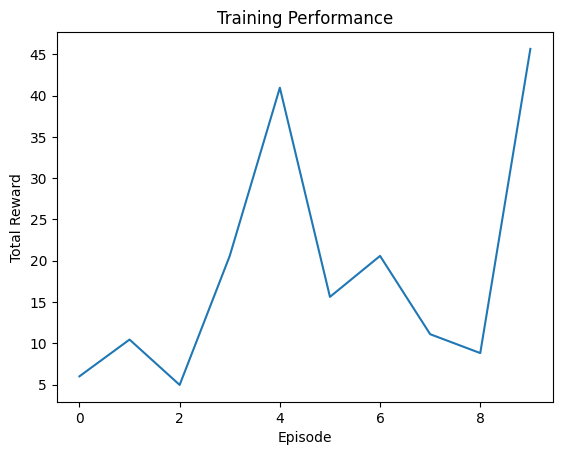

In [2]:
import gymnasium as gym
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import highway_env

# Chargement de la configuration
with open("config/1-highway-discrete-config.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("highway-fast-v0", render_mode="human")
env.unwrapped.configure(config)
observation, _ = env.reset()

# Fonctions d'aide
def is_risky(state):
    """
    Détermine si l'état (observation) présente un risque pour l'accélération.
    On considère que l'observation est issue d'une grille d'occupation.
    
    Utilise la configuration sous config["observation"]:
      - grid_size et grid_step se trouvent dans config["observation"]["grid_size"] et ["grid_step"].
    On considère risqué si, dans la colonne la plus à droite de la grille, 
    une cellule indique la présence d'un véhicule (valeur > 0.5).
    """
    # Correction : accès aux clés imbriquées dans "observation"
    grid_range = config["observation"]["grid_size"][0]  # par exemple [-20, 20] pour l'axe x
    grid_step = config["observation"]["grid_step"][0]     # par exemple 5
    # Calcul du nombre de cellules sur l'axe x et y
    nx = int((grid_range[1] - grid_range[0]) / grid_step)
    ny = int((config["observation"]["grid_size"][1][1] - config["observation"]["grid_size"][1][0]) / config["observation"]["grid_step"][1])
    
    num_features = 7  # d'après la config : ['presence', 'x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']
    
    # On s'assure que la taille de state est bien nx * ny * num_features
    if state.size != nx * ny * num_features:
        return False  # On considère par défaut que l'état est sûr si la taille ne correspond pas.
    
    grid = state.reshape(nx, ny, num_features)
    # On considère "le front" comme la colonne la plus à droite (indice -1 sur l'axe x)
    front_presence = grid[-1, :, 0]  # Feature 0 correspond à la présence
    # Si une cellule du front indique la présence d'un véhicule (valeur supérieure à 0.5), on considère le contexte comme risqué.
    if np.any(front_presence > 0.5):
        return True
    return False

def shape_reward(reward, action, state):
    """
    Applique le reward shaping :
      - Si la reward indique une collision (par exemple la valeur 'collision_reward' de la config),
        on renforce la pénalité.
      - Si l'action est d'accélérer (ici action == 1) dans un contexte risqué, on applique un malus supplémentaire.
      - On ajoute ensuite un offset positif (ici +0.5) pour équilibrer le signal.
    """
    shaped = reward
    # 1. Renforcer la pénalisation des collisions.
    if reward <= config.get("collision_reward", -1):
        shaped = reward * 2  # Pénalité plus sévère.
    
    # 2. Pénaliser l'accélération agressive si l'état est risqué.
    if action == 1 and is_risky(state):
        shaped -= 0.5  # Malus supplémentaire.
    
    return shaped

# Définition du réseau DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Agent avec Double DQN et action masking
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, batch_size=64):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)

        self.replay_buffer = deque(maxlen=100000)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = batch_size
        self.action_dim = action_dim

    def get_action(self, state):
        # En mode exploration, on applique un filtrage sur les actions dangereuses.
        if np.random.rand() < self.epsilon:
            available_actions = list(range(self.action_dim))
            # Action masking : si l'état est risqué, retirer l'action "accélérer" (index 1) de la sélection.
            if is_risky(state) and 1 in available_actions:
                available_actions.remove(1)
                if len(available_actions) == 0:
                    available_actions = [1]
            return random.choice(available_actions)

        # En mode exploitation, on ajuste les Q-values pour éviter l'accélération si l'état est risqué.
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_tensor).squeeze(0).numpy()
        if is_risky(state):
            q_values[1] = -float('inf')
        return int(np.argmax(q_values))
    
    def update_epsilon(self, current_episode, total_episodes):
        """
        Met à jour epsilon avec décroissance habituelle.
        Après la moitié des épisodes, on fixe epsilon à sa valeur minimale.
        """
        if current_episode > total_episodes // 2:
            self.epsilon = self.epsilon_min
        else:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Calcul des Q-values actuels sur le réseau principal
        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            # Double DQN :
            # 1. Sélection de l'action optimale pour l'état suivant avec le réseau principal.
            next_actions = self.q_net(next_states).argmax(dim=1, keepdim=True)
            # 2. Évaluation de ces actions avec le réseau cible.
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target = rewards + self.gamma * (1 - dones) * next_q_values

        loss = F.mse_loss(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        # (Optionnel) Le gradient clipping peut être ajouté ici.
        # torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), max_norm=1.0)
        self.optimizer.step()

def train(agent, env, episodes=200, sync_target_every=10):
    all_rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        state = state.flatten()  # Ajuster la forme si nécessaire
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = next_state.flatten()
            done = terminated or truncated

            # Appliquer le reward shaping (en prenant en compte l'action et l'état)
            shaped_reward = shape_reward(reward, action, state)
            agent.replay_buffer.append((state, action, shaped_reward, next_state, done))
            agent.update()

            state = next_state
            total_reward += reward  # Pour le suivi, on cumule la reward originale

        agent.update_epsilon(ep, episodes)
        agent.scheduler.step()
        all_rewards.append(total_reward)

        if ep % sync_target_every == 0:
            agent.target_net.load_state_dict(agent.q_net.state_dict())

        current_lr = agent.optimizer.param_groups[0]['lr']
        if ep % 10 == 0:
            print(f"Episode {ep}: Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.4f}, LR = {current_lr:.6f}")

    return all_rewards

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.show()

# Fonction principale
if __name__ == "__main__":
    # Détermination de la dimension de l'état et du nombre d'actions
    state_dim = observation.flatten().shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim, lr=1e-3, batch_size=64)
    rewards = train(agent, env, episodes=10, sync_target_every=10)
    plot_rewards(rewards)



In [ ]:
def simulate_infinite(agent, env):
    """
    Cette fonction lance une simulation en boucle infinie afin de démontrer
    que la voiture continue d'avancer. À la fin de chaque épisode (collision, fin de simulation),
    l'environnement est automatiquement réinitialisé.
    """
    state, _ = env.reset()
    state = state.flatten()
    while True:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = next_state.flatten()

        # Réinitialisation de l'environnement en fin d'épisode
        if terminated or truncated:
            print("Réinitialisation de l'environnement...")
            state, _ = env.reset()
            state = state.flatten()

        # Optionnel : ajuster la vitesse de simulation pour observation
        #time.sleep(0.01)

simulate_infinite(agent, env)

Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
Réinitialisation de l'environnement...
